# DM - Classification [TASK 3]

Library imports and initial settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import math
import itertools

import statistics
from wittgenstein import RIPPER
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in clustering phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info

<bound method DataFrame.info of        Unnamed: 0  statuses_count  bot  tweets_num  tweets_2020_num  \
0               0              76    1         118              118   
1               1              54    0         104              104   
2               2               3    1           3                3   
3               3              50    1        1253             1253   
4               4            7085    0        3217             3217   
...           ...             ...  ...         ...              ...   
11503       11503            1126    0         991              991   
11504       11504            3024    0        1853             1853   
11505       11505               6    0           6                6   
11506       11506              42    1          91               91   
11507       11507            5279    0        3301             3301   

       likes_num  comments_num  ratio_likes_x_tweets   entropy  \
0            5.0           0.0              0.042

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

In [5]:
def gridsearch(train_set, train_label, create_model, params_list):
    best_test_score = None
    best_params = {}
    for params in params_list:
        model = create_model(params)
        scores = cross_validate(model, train_set, train_label, cv=4)
        new_test_score = statistics.mean(scores['test_score'])
        if best_test_score is None or new_test_score > best_test_score:
            best_test_score = new_test_score
            best_params = params
    return best_test_score, best_params

In [6]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

In [7]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

### Decision tree

In [8]:
def create_dt(params):
    return DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=params["max_depth"], min_samples_leaf=params["min_samples_leaf"])

In [9]:
max_depths = [5, 10, 20, 30, 40, 50]
min_samples_leafs = [1, 2, 3, 4, 5]

params = [dict(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
) for max_depth, min_samples_leaf in itertools.product(max_depths, min_samples_leafs)]

best_test_score, best_params = gridsearch(train_set, train_label, create_dt, params)

best_test_score, best_params

(0.8256571482727073, {'max_depth': 10, 'min_samples_leaf': 5})

In [10]:
dt = create_dt(best_params)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

In [11]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [12]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.74      0.83      4313
         bot       0.81      0.97      0.88      4893

    accuracy                           0.86      9206
   macro avg       0.88      0.86      0.86      9206
weighted avg       0.88      0.86      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.90      0.69      0.78      1079
         bot       0.77      0.93      0.84      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.81      2302
weighted avg       0.83      0.82      0.81      2302



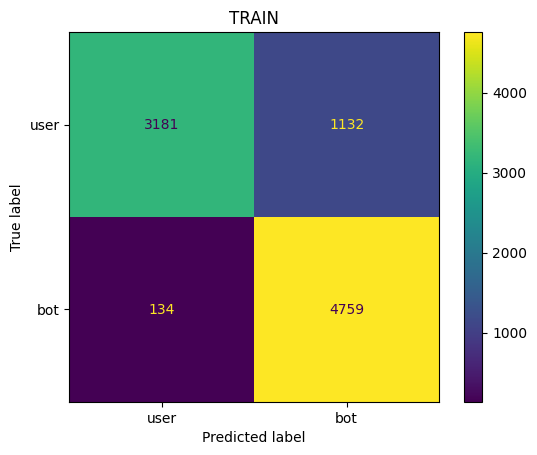

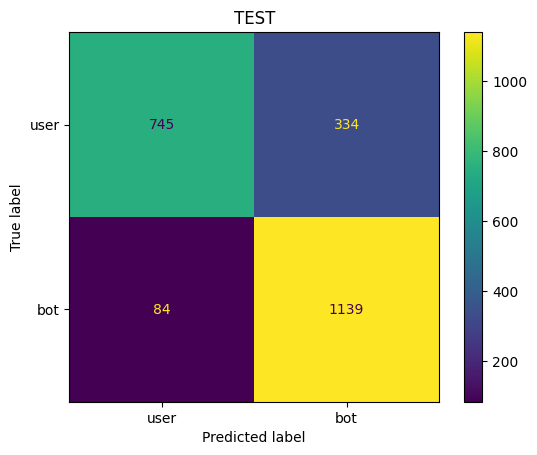

In [13]:
plot_cms(train_pred_dt, test_pred_dt)

### K-Nearest Neighbors

In [14]:
def create_knn(params):
    return KNeighborsClassifier(n_neighbors=params['k'])

In [15]:
params = [dict(k=k) for k in list(range(1, int(math.sqrt(train_set.shape[0]))))]

best_test_score, best_params = gridsearch(train_set, train_label, create_knn, params)

best_test_score, best_params

(0.7334360726326445, {'k': 35})

In [16]:
knn = create_knn(best_params)
knn = knn.fit(train_set, train_label)

In [17]:
train_pred_knn = knn.predict(train_set)
test_pred_knn = knn.predict(test_set)

In [18]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.85      0.55      0.67      4313
         bot       0.70      0.91      0.79      4893

    accuracy                           0.74      9206
   macro avg       0.77      0.73      0.73      9206
weighted avg       0.77      0.74      0.73      9206

TEST
              precision    recall  f1-score   support

        user       0.83      0.56      0.67      1079
         bot       0.70      0.90      0.79      1223

    accuracy                           0.74      2302
   macro avg       0.77      0.73      0.73      2302
weighted avg       0.76      0.74      0.73      2302



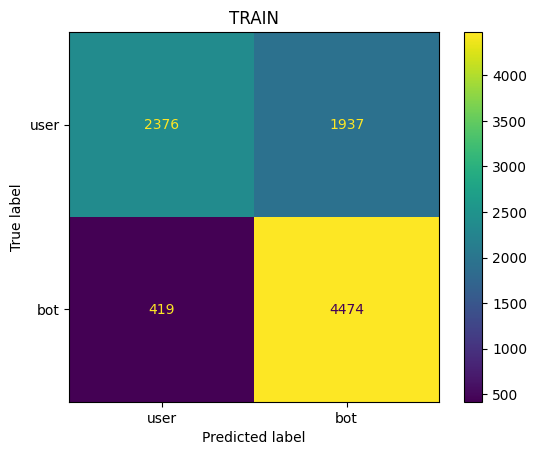

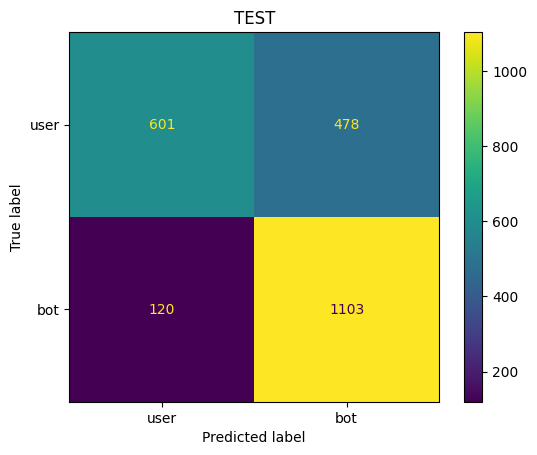

In [19]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

In [20]:
# RIPPER doesn't work with entropy rounded more than 4
train_set_rb = train_set.copy()
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

In [21]:
def create_rb(params):
    return RIPPER(k=params['k'], prune_size=params['prune_size'])

In [22]:
ks = [1, 2]
prune_sizes = [0.33, 0.5]

params = [dict(
    k=k,
    prune_size=prune_size
) for k, prune_size in itertools.product(ks, prune_sizes)]

best_test_score, best_params = gridsearch(train_set_rb, train_label, create_rb, params)

best_test_score, best_params

(0.7853565159408273, {'k': 2, 'prune_size': 0.5})

In [23]:
rb = create_rb(best_params)
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm.

In [24]:
rb.out_model()

[[entropy=<0.0001 ^ statuses_count=<20.0 ^ mean_pub_range=392346.05-800382.94 ^ ratio_likes_x_tweets=<0.015] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-59.0 ^ mean_texts_similarity=0.015-0.017 ^ tweets_num=102.0-121.0 ^ mean_pub_range=96781.24-115819.39] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-59.0 ^ likes_num=1.0-4.0 ^ mean_texts_similarity=0.013-0.014] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-59.0] V
[mean_texts_similarity=0.021-0.024 ^ texts_special_chars_length=5.42-5.84 ^ texts_mean_length=82.26-89.53] V
[entropy=<0.0001 ^ statuses_count=35.0-45.0] V
[entropy=0.0001-0.0002 ^ statuses_count=35.0-45.0] V
[entropy=<0.0001 ^ statuses_count=<20.0] V
[entropy=0.0001-0.0002 ^ texts_special_chars_length=3.4-3.72 ^ Unnamed:0=<1151.5] V
[entropy=0.0001-0.0002 ^ statuses_count=68.0-116.0 ^ tweets_num=121.0-340.0] V
[entropy=0.0001-0.0002 ^ tweets_num=102.0-121.0 ^ mean_texts_similarity=0.014-0.015 ^ texts_special_chars_length=3.

In [25]:
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

In [26]:
report_scores(train_pred_rb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.80      0.69      0.74      4313
         bot       0.75      0.85      0.80      4893

    accuracy                           0.77      9206
   macro avg       0.78      0.77      0.77      9206
weighted avg       0.78      0.77      0.77      9206

TEST
              precision    recall  f1-score   support

        user       0.86      0.65      0.74      1079
         bot       0.75      0.90      0.82      1223

    accuracy                           0.79      2302
   macro avg       0.80      0.78      0.78      2302
weighted avg       0.80      0.79      0.78      2302



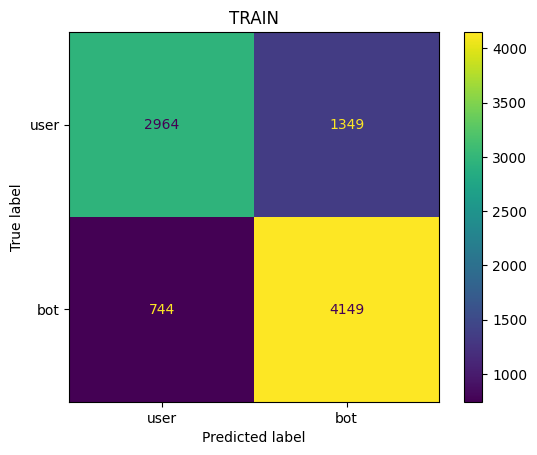

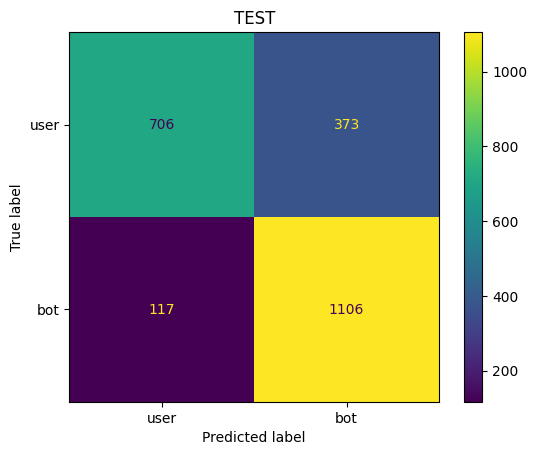

In [27]:
plot_cms(train_pred_rb, test_pred_rb)